In [2]:
cfg={
    'main_folder':'/Users/matejkvassay/data/sketch-testing/',
    'save_allowed':True,
    'dataset_file':'dataset.npy',
    'dev_mode': False,
    'dev_mode_dataset_count_limit': 1000,
    'dist_estimation_ref_obj_count': 100,
    'dist_estimation_p_vals':[1,2],
    'evaluation_set_query_obj_cnt':1000,
    'evaluation_set_result_set_size':100,
    'ghp_pivot_couple_candidates': 5000,
    'min_balancing_score': 0.1,
    'after_partitiong_checkpoint_file': 'after_partitioning.checkpoint'
}

In [3]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from scipy.spatial.distance import minkowski, hamming
from fractions import Fraction 
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import pylab
import scipy as sp
import cPickle

In [4]:
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [353]:
def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f)

def show_text(title,xlabel,ylabel):
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def heatmap(x,y,bins=50,figsize=(5,5),title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=figsize)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    show_text(title,xlabel,ylabel)
    plt.show()
    
def scatter(x,y,title=None, xlabel=None, ylabel=None, point_size=5):
    plt.scatter(x, y, s=[point_size for _ in range(len(x))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def scatter_array(arr, title=None, xlabel=None, ylabel=None, point_size=5):
    ser=pd.Series(arr)
    plt.scatter(ser.index, ser, s=[point_size for _ in range(len(arr))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_array(arr, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).plot(grid=True)
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def hist_array(arr,bins=50, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).hist(bins=bins,grid=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    plt.show()
    
def restrict_2d_space(x,y,x_interval, y_interval):
    conditions=[x>=x_interval[0], x<=x_interval[1], y>=y_interval[0], y<=y_interval[1]]
    mask=conditions[0]
    for condition in conditions[1:]:
        mask=np.logical_and(mask,condition)
    return x[mask], y[mask]


def balanced_correlation(col1, col2):
    '''
    Correlation when bits are balanced - |4*(a/n) - 1|, where a is CARD(NOT(XOR(A,B)))
    '''
    a=float(np.sum(np.logical_not(np.logical_xor(v1,v2))))
    n=col1.shape[0]
    return np.absolute((4.0*(a/n)) - 1.0)

class IterationLogger(object):
    def __init__(self, message='Started iteration no.: %s\n Time from previous iteration: %ss\n Time from start: %ss',log_by=1000):
        self.log_by=log_by
        self.num_iter=0
        self.msg=message
        self.time_started=None
        self.time_this_iter=None
        
    def next_iter(self):
        if self.time_this_iter is None:
            self.time_this_iter=time()
        if self.time_started is None:
            self.time_started=time()
        self.num_iter+=1
        if self.num_iter%self.log_by==0:
            dur_from_previous=time()-self.time_this_iter
            self.time_this_iter=time()
            dur_from_start=time()-self.time_started
            log_pfx(self, self.msg, str(self.num_iter), str(dur_from_previous), str(dur_from_start))
            

### LOAD DATA

In [5]:
dataset_path=cfg['main_folder']+cfg['dataset_file']

In [6]:
with open(dataset_path, 'rb') as f:
    decaf_vecs=np.load(f)
if cfg['dev_mode']:
    decaf_vecs=decaf_vecs[:cfg['dev_mode_dataset_count_limit']]
obj_ids=np.arange(len(decaf_vecs))

In [7]:
decaf_vecs.shape #(vectors count, vector length)

(69318, 4096)

### DATA ANALYSIS


#### Distance distribution estimation

In [8]:
def estimate_minkowski_dist_distr(vec_matrix, ref_obj_cnt, p):
    '''
    p can be either single value or list of p parameters for minkowski distance
    '''
    distances=[list() for _ in range(len(p))]
    reference_objs=vec_matrix[np.random.choice(vec_matrix.shape[0], size=ref_obj_cnt, replace=False)] #sampling without replacement
    iter_log=IterationLogger(log_by=5000)
    for decaf_vec in decaf_vecs:
        iter_log.next_iter()
        for ref_obj in reference_objs:
            for i, val_p in enumerate(p):
                dist=minkowski(ref_obj, decaf_vec, p=val_p)
                distances[i].append(dist)
    return tuple(distances)


In [9]:
dist_l1, dist_l2 = estimate_minkowski_dist_distr(decaf_vecs,  cfg['dist_estimation_ref_obj_count'], cfg['dist_estimation_p_vals'])

2017-04-29 15:38:55,459 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 26.5622060299s
 Time from start: 26.5622060299s
2017-04-29 15:39:24,487 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 29.0281610489s
 Time from start: 55.5903680325s
2017-04-29 15:39:53,225 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 28.7380218506s
 Time from start: 84.3283910751s
2017-04-29 15:40:21,954 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 28.7288680077s
 Time from start: 113.057260036s
2017-04-29 15:40:49,924 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 27.9704780579s
 Time from start: 141.027739048s
2017-04-29 15:41:15,928 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 26.0039708614s
 Time from start: 167.031710863s
2017-04-29 

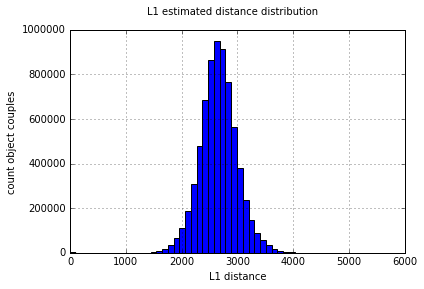

In [10]:
hist_array(dist_l1, bins=50, title='L1 estimated distance distribution',ylabel='count object couples', xlabel='L1 distance')

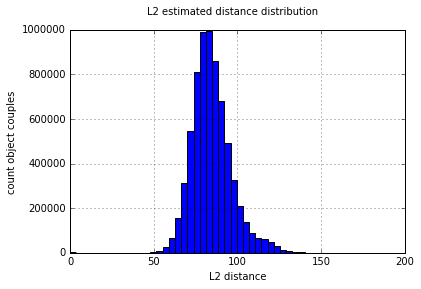

In [11]:
hist_array(dist_l2, bins=50,title='L2 estimated distance distribution',ylabel='count object couples', xlabel='L2 distance')

## APPROXIMATION  EVALUATION SET
We select 100 query objects and their 100 closest object's id's from the dataset to evaluate. It simulates the scenario where almost never more than 100 objects are required for result set. 

In [12]:
eval_queries_indicies=np.random.choice(decaf_vecs.shape[0], size=cfg['evaluation_set_query_obj_cnt'], replace=False)
eval_queries_vecs=decaf_vecs[eval_queries_indicies] 
eval_queries_ids=obj_ids[eval_queries_indicies]
eval_k=cfg['evaluation_set_result_set_size'] #k for knn to evaluation objects

In [13]:
eval_result_objs=[list() for _ in range(len(eval_queries_ids))]

Finds k-NN query result

In [14]:
iter_log=IterationLogger(log_by=5000)
for i in range(len(decaf_vecs)):
    iter_log.next_iter()
    candidate_vec=decaf_vecs[i]
    candidate_id=obj_ids[i]
    for j in range(len(eval_queries_vecs)):
        query_vec=eval_queries_vecs[j]
        dist=minkowski(candidate_vec, query_vec, p=1)
        if len(eval_result_objs[j])>0:
            if dist<eval_result_objs[j][-1][1]: #if object is not member of result set
                eval_result_objs[j].append((candidate_id, dist))
                eval_result_objs[j].sort(key=lambda x: x[1],reverse=False)
                if len(eval_result_objs[j])>eval_k:#if > k objects remove last one
                    del eval_result_objs[j][-1] 
        else:
            eval_result_objs[j].append((candidate_id, dist))
            

2017-04-29 15:47:02,815 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 144.796949148s
 Time from start: 144.796947956s
2017-04-29 15:49:11,505 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 128.690979004s
 Time from start: 273.487927914s
2017-04-29 15:51:15,464 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 123.958784819s
 Time from start: 397.446712971s
2017-04-29 15:53:30,803 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 135.33919096s
 Time from start: 532.785904884s
2017-04-29 15:55:42,089 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 131.285347939s
 Time from start: 664.071253777s
2017-04-29 15:57:52,676 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 130.586852074s
 Time from start: 794.658106804s
2017-04-29 1

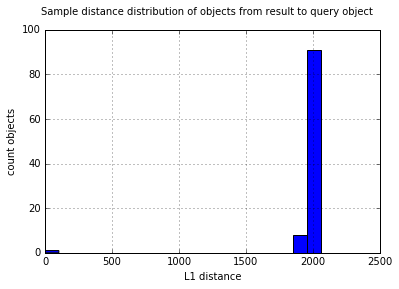

In [15]:
hist_array([obj[1] for obj in eval_result_objs[17]],bins=20,title='Sample distance distribution of objects from result to query object',xlabel='L1 distance',ylabel='count objects')

## GENERALIZED HYPERPLANE PARTITIONING PIVOTS SELECTION

In [16]:
pivot_cand_cpl_cnt=cfg['ghp_pivot_couple_candidates']

Select random pivot couples

In [17]:
cand_indicies=np.random.choice(decaf_vecs.shape[0], size=pivot_cand_cpl_cnt*2, replace=False)
pivot_cand_vecs=decaf_vecs[cand_indicies]
pivot_cand_ids=obj_ids[cand_indicies]
pivot_cand_vecs_a, pivot_cand_vecs_b=np.split(pivot_cand_vecs,2)
pivot_cand_ids_a, pivot_cand_ids_b=np.split(pivot_cand_ids,2)
pivot_cand_vecs=np.array(zip(pivot_cand_vecs_a, pivot_cand_vecs_b))
pivot_cand_ids=np.array(zip(pivot_cand_ids_a, pivot_cand_ids_b))

In [18]:
def get_ghp_partition(obj, pivot_a, pivot_b, p=1):
    '''
    returns partition 0/1 and distance to closest pivot
    '''
    dist_a=minkowski(vec, pivot_cpl_vec[0], p=p)
    dist_b=minkowski(vec, pivot_cpl_vec[1], p=p)
    if dist_a<dist_b:
        return 1, dist_a
    if dist_a>dist_b:
        return 0, dist_b
    return np.random.choice([0,1]), dist_a
    
def compute_part_balance(cnt_partition, cnt_all):
    '''
    1 - 2*|0.5-x/y| where x is count members in left or right partition and y is count all members
    '''
    return 1.0-(2*abs(0.5-(cnt_partition/cnt_all)))

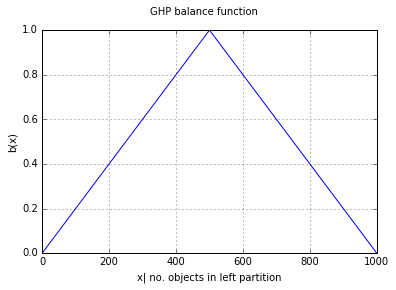

In [19]:
#plot balance function
plot_array([compute_part_balance(float(num),float(1000)) for num in range(0,1001)], title='GHP balance function',xlabel='x| no. objects in left partition',ylabel='b(x)')



Partition all objects from database and collect useful statistics for pivot couple selection

In [20]:
partitions=np.zeros(shape=(decaf_vecs.shape[0], len(pivot_cand_ids)), dtype=np.float32)
left_members_cnt=np.zeros(len(pivot_cand_ids), dtype=np.float32)
sum_dist_from_ghp=np.zeros(len(pivot_cand_ids), dtype=np.float32)

In [21]:
iter_log=IterationLogger(log_by=1000)
for i, vec in enumerate(decaf_vecs):
    iter_log.next_iter()
    for j, pivot_cpl_vec in enumerate(pivot_cand_vecs):
        partition,dist=get_ghp_partition(vec, pivot_cpl_vec[0], pivot_cpl_vec[1], p=1)
        partitions[i][j]=partition
        left_members_cnt[j]+=partition
        sum_dist_from_ghp[j]+=dist

2017-04-29 16:20:06,638 - root - INFO - IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 266.992723942s
 Time from start: 266.992719889s
2017-04-29 16:24:33,634 - root - INFO - IterationLogger| Started iteration no.: 2000
 Time from previous iteration: 266.996590137s
 Time from start: 533.989311934s
2017-04-29 16:29:00,959 - root - INFO - IterationLogger| Started iteration no.: 3000
 Time from previous iteration: 267.324573994s
 Time from start: 801.313885927s
2017-04-29 16:33:28,624 - root - INFO - IterationLogger| Started iteration no.: 4000
 Time from previous iteration: 267.665231943s
 Time from start: 1068.97911882s
2017-04-29 16:37:56,091 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 267.467139006s
 Time from start: 1336.44625902s
2017-04-29 16:42:24,360 - root - INFO - IterationLogger| Started iteration no.: 6000
 Time from previous iteration: 268.268931866s
 Time from start: 1604.71519184s
2017-04-29 16:46

Checkpoint

In [22]:
#Partitioning balance score
balance_scores=np.array([compute_part_balance(float(cnt), float(decaf_vecs.shape[0])) for cnt in left_members_cnt])

In [23]:
'''
Partitioning with low balancing score is useless for filtering thus we'll remove such pivot couples right away. 
'''
balance_limit=float(cfg['min_balancing_score'])
bal_mask=np.array([i for i, score in enumerate(balance_scores) if score>=balance_limit])
balance_scores=balance_scores[bal_mask]
pivot_cand_vecs=pivot_cand_vecs[bal_mask]
partitions=np.array(partitions).T[bal_mask].T
left_members_cnt=np.array(left_members_cnt)[bal_mask]
sum_dist_from_ghp=np.array(sum_dist_from_ghp)[bal_mask]

In [24]:
'''
Compute distance from dividing hyperplane score.
Scale all distances to 0-1, 1 being the largest.
HP distance score: (d_i - min(D))/(max(D)-min(D))
'''
avg_dist_from_hp=np.array([float(num)/decaf_vecs.shape[0] for num in sum_dist_from_ghp])

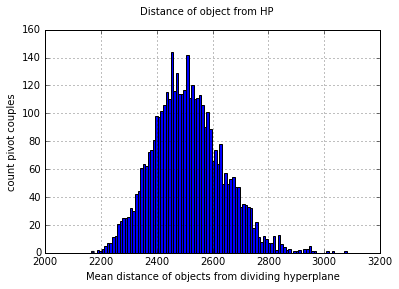

In [47]:
hist_array(avg_dist_from_hp, bins=100,xlabel='Mean distance of objects from dividing hyperplane', \
           ylabel='count pivot couples',title='Distance of object from HP')

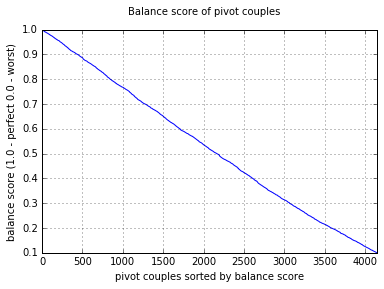

In [48]:
plot_array(sorted(balance_scores,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

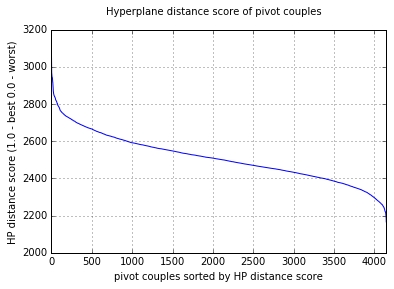

In [49]:
plot_array(sorted(avg_dist_from_hp,reverse=True),title='Hyperplane distance score of pivot couples', ylabel='HP distance score (1.0 - best 0.0 - worst)', xlabel='pivot couples sorted by HP distance score')

### Checkpoint

Save

In [52]:
if cfg['save_allowed']:
    save_to((decaf_vecs, eval_queries_vecs,eval_queries_ids, eval_k, pivot_cand_vecs,eval_result_objs,\
             pivot_cand_ids, partitions, balance_scores, avg_dist_from_hp),\
            cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])

Load

In [6]:
decaf_vecs, eval_queries_vecs,\
eval_queries_ids, eval_k, \
pivot_cand_vecs,eval_result_objs,\
pivot_cand_ids, partitions, balance_scores,\
avg_dist_from_hp=load_from(cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])

In [12]:
res=np.argmax(balance_scores, axis=None)

### Select balanced bits

In [406]:
balance_indicies=balance_scores.argsort()[::-1]
balance_indicies=balance_indicies[:500]
pivot_cand_vecs_bal=pivot_cand_vecs[balance_indicies]
pivot_cand_ids_bal=pivot_cand_ids[balance_indicies]
balance_scores_bal=balance_scores[balance_indicies]
correlations_bal=correlations[balance_indicies]
avg_dist_from_hp_bal=avg_dist_from_hp[balance_indicies]
partitions_bal=partitions.T[balance_indicies].T

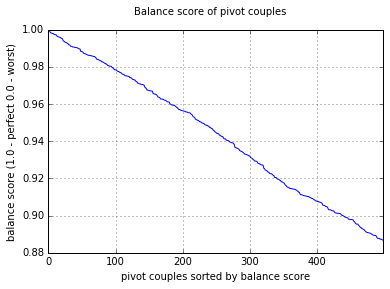

In [407]:
plot_array(sorted(balance_scores_bal,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

### Difference in mean distance from hyperplane after removing unbalanced bits
Removing unbalanced bits doesn't change distance from dividing hyperplane much.

In [408]:
np.mean(avg_dist_from_hp)

2510.5736894431689

In [409]:
np.mean(avg_dist_from_hp_bal)

2520.3137170720452

### Removing correlated bits
We'll obtain least mutually correlated subset of bits using greedy heuristic. In each iteration we'll remove bit that contributes to mean pairwise correlations the most. 

In [536]:
def compute_corr_mtx(sketch_matrix):
    corr_mtx = np.absolute(np.corrcoef(sketch_matrix.T))
    np.fill_diagonal(corr_mtx, 0.0)
    return corr_mtx

def mean_corr(corr_mtx, include=None, exclude=None):
    if not include and not exclude:
        u=np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)
        return np.mean(corr_mtx[u])
    if include:
        selection=corr_mtx[include].T[include]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.mean(selection[u])
    if exclude:
        mask = np.ones(corr_mtx.shape[0],dtype=bool)
        mask[exclude]=0
        print(mask.shape)
        selection=corr_mtx[mask].T[mask]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.mean(selection[u])

def max_corr(corr_mtx, include=None, exclude=None):
    if include is None and exclude is None:
        u=np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)
        return np.max(corr_mtx[u])
    if include is not None:
        selection=corr_mtx[include].T[include]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.max(selection[u])
    if exclude is not None:
        mask = np.ones(corr_mtx.shape[0],dtype=bool)
        mask[exclude]=0
        print(mask.shape)
        selection=corr_mtx[mask].T[mask]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.max(selection[u])

In [537]:
M=compute_corr_mtx(partitions_bal)

In [576]:
sketch_lengths=range(2,40,1)

#### Algorithm 1
Select K random subsets of specified length and choose the one with minimal pairwise correlation.

In [577]:
max_corr(M, include=[2,3,4,1,5,38])

0.57649659573012635

In [578]:
def select_random_bit_subset(sketch_matrix, desired_length, k):
    indices=np.array(range(sketch_matrix.shape[1]))
    subsets=np.array([np.random.choice(indices,size=desired_length, replace=False) for _ in range(k)])
    best_subset=None
    best_corr=1.0
    for subset_idx in subsets:
        corr=max_corr(M, include=subset_idx)
        if corr<=best_corr:
            best_corr=corr
            best_subset=subset_idx
    return best_subset,best_corr

In [579]:
K=100
found_corrs=list()
        
for sketch_length in sketch_lengths:
    _, best_corr=select_random_bit_subset(partitions_bal, sketch_length,k=K)
    found_corrs.append(best_corr)

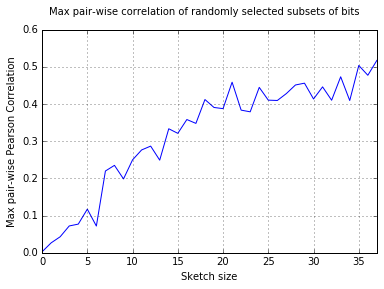

In [580]:
plot_array(found_corrs,title='Max pair-wise correlation of randomly selected subsets of bits', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

#### Algorithm 2
Select bits with minimal sum of values in correlation matrix M. Seems to work well for small sketch sizes (8-16)

In [581]:
found_corrs=list()

In [582]:
for length in sketch_lengths:
    indices=np.sum(M,axis=1).argsort()[:length]
    found_corrs.append(max_corr(M, include=indices))
    

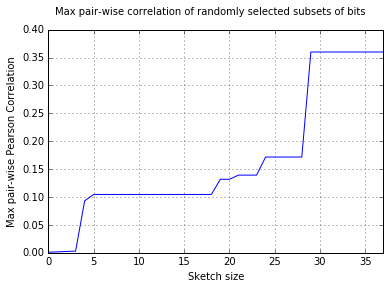

In [583]:
plot_array(found_corrs,title='Max pair-wise correlation of randomly selected subsets of bits', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

#### Algorithm 3
Start with initial selected least correlated column and add one in each iteration, which will result to minimal increase in sum of correlations

In [551]:
least_correlated=np.argmin(np.sum(M, axis=1))

272

#### Algorithm 3 
Start with multiple initial vectors with minimal correlation and to each one of them add one new, which increases correlation minimally and finally join best tuples.

#### Algorithm 4 - from Vladimir's Improving Sketches paper

In [ ]:
def select_bits(corr_mtx, desired_size, par_k=10, par_i=1000):
    min_max_corr=100
    indices=list()
    cm=np.absolute(corr_mtx)
    np.fill_diagonal(cm, 0.0)
    for k in range(par_k):
        for i in range(par_i)
            curr_idx=list()
            np.random.randint(cm.shape[1])
    

In [242]:
v1=np.array([0,1,0,1,1])
v2=np.array([0,0,1,1,1])

In [211]:
np.sum(np.logical_not(np.logical_xor(v1,v2)))

3

In [212]:
v1.shape

(5,)

In [ ]:
def max_couple_correlation(sketch_matrix):
    corr_mtx = np.absolute(np.corrcoef(sketch_matrix.T)) #matrix of correlations of columns of sketch matrix
    np.fill_diagonal(corr_mtx, 0.0)
    return np.max(corr_mtx)

In [246]:
max_couple_correlation(partitions_bal[[3,4,5]])

nan

In [494]:
selection=M[[0,1,2]].T[[0,1,2]]

In [495]:
u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
u

(array([0, 0, 1]), array([1, 2, 2]))

In [496]:
selection[u]

array([ 0.40811343,  0.08046511,  0.39701927])